In [240]:
import pandas as pd
import numpy as np
import math
import os

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import ipywidgets as widgets
from ipywidgets import interact, interactive
from IPython.display import display

In [241]:
%matplotlib inline

In [242]:
df = pd.read_csv("price_data.csv")

# Set first column name
df.columns.values[0] = "Stock"

# Make that column indexes (row)
df = df.set_index('Stock')

# Make columns datetime
df.columns = pd.to_datetime(df.columns)

# Make all numeric
df = df.apply(pd.to_numeric, errors="coerce")

# drop row if all NaN
df.dropna(how='all', inplace=True)

# drop column if all NaN
df.dropna(how='all', axis=1, inplace=True)

In [243]:
df.head()

,1990-01-31 00:00:00,1990-02-28 00:00:00,1990-03-30 00:00:00,1990-04-30 00:00:00,1990-05-31 00:00:00,1990-06-29 00:00:00,1990-07-31 00:00:00,1990-08-31 00:00:00,1990-09-28 00:00:00,1990-10-31 00:00:00,...,2017-09-29 00:00:00,2017-10-31 00:00:00,2017-11-30 00:00:00,2017-12-29 00:00:00,2018-01-31 00:00:00,2018-02-28 00:00:00,2018-03-30 00:00:00,2018-04-30 00:00:00,2018-05-31 00:00:00,2018-06-29 00:00:00
Stock,,,,,,,,,,,,,,,,,,,,,
2S TB Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.27,3.98,4.39,4.44,4.30,4.20,4.00,3.78,3.5,3.06
A TB Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.50,6.55,6.55,6.60,6.65,6.70,6.70,6.70,6.7,6.70
AAV TB Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.55,6.40,6.20,6.15,5.70,5.55,5.15,5.85,5.5,5.00
ABICO TB Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.75,9.75,9.20,9.45,8.85,7.85,7.95,7.85,6.3,5.95
ABPIF TB Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.45,8.60,8.55,8.55,8.90,8.70,8.50,8.55,8.5,8.50


In [244]:
print("Left with {} stocks, and {} date columns".format(df.shape[0], df.shape[1]))

Left with 743 stocks, and 342 date columns


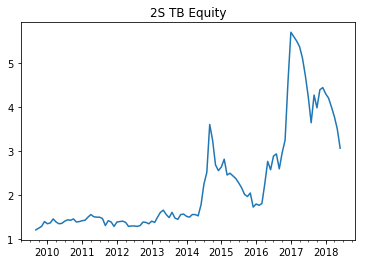

In [245]:
@interact(index=(0,len(df.index)-1))
def view_stocks(index=0):
    i = index
    df.iloc[i].plot(kind='line', title=df.index[i])

## Strategy Calculation (Holding-Observing)

o, h is period of time in months (o = observing/h = hoding)

In [246]:
# calculate sum of winner/loser deciles on holding period
def sum_decile_winners_losers_hold(RO, RH, irange, debug_list=False):
    i = irange
    ro, rh = RO[:, i], RH[:, i]

    # Concat o, h
    oh = np.vstack([ro, rh]).T
    
    # remove rows that have nan
    oh = oh[~np.isnan(oh).any(axis=1)]

    # sort by winners in observing period
    sorted_inds_desc = oh[:,0].argsort()[::-1]
    oh = oh[sorted_inds_desc]

    # get decile range
    decile_num = math.ceil(oh.shape[0]/10)

    winners = oh[:decile_num]
    losers = oh[-decile_num:]
    
    if debug_list:        
        return (winners, losers)

    sum_winners_hold = winners[:,1].sum()
    sum_losers_hold = losers[:,1].sum()
    return (sum_winners_hold, sum_losers_hold)
    

# o, h is number of months
def strategy(o, h, M):
    nrows, ncols = M.shape
    
    oh_total_range = o+1+h
    num_possible_ranges = ncols - oh_total_range + 1
    
    if num_possible_ranges <= 0:
        raise ValueError('num_possible_ranges must > 0.')
    
    RO = np.zeros([nrows, num_possible_ranges])
    RH = np.zeros([nrows, num_possible_ranges])

    # for each stock
    for r in range(nrows):
        
        # for each o/h range til the end
        for ic in range(num_possible_ranges):
            
            m = M[r, ic:ic+oh_total_range] # get that range
            if np.isnan(m).any(): # one value is nan -> ignore stock at this range
                RO[r, ic] = np.nan
                RH[r, ic] = np.nan
                continue
                
            p0 = m[0] # start
            p1 = m[o] # start - observe
            p2 = m[o + h] # observe - hold
            
            # Handle divided by 0
            if p0 == 0:
                returnO = 0
            else:
                returnO = p1/p0 - 1
                
                
            if p1 == 0:
                returnH = 0
            else:
                returnH = p2/p1 - 1                
                
            RO[r, ic]= returnO
            RH[r, ic] = returnH
    
    S_W = np.zeros(num_possible_ranges)
    S_L = np.zeros(num_possible_ranges)
    
    # calculate sum of winner/loser on holding period
    for i in range(num_possible_ranges):
        sw, sl = sum_decile_winners_losers_hold(RO, RH, i)
        S_W[i] = sw
        S_L[i] = sl
        
    return np.vstack([S_W, S_L]).T
    

## Add Date, Year, and Month columns for easier selection

In [247]:
dft = df.T
dft['Date'] = dft.index
dft['Year'] = dft['Date'].apply(lambda dt: dt.year)
dft['Month'] = dft['Date'].apply(lambda dt: dt.month)
dft.head()

Stock,2S TB Equity,A TB Equity,AAV TB Equity,ABICO TB Equity,ABPIF TB Equity,ACAP TB Equity,ACC TB Equity,ADB TB Equity,ADVANC TB Equity,AEC TB Equity,...,WINNER TB Equity,WORK TB Equity,WPH TB Equity,XO TB Equity,YUASA TB Equity,ZIGA TB Equity,ZMICO TB Equity,Date,Year,Month
1990-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990-01-31,1990,1
1990-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990-02-28,1990,2
1990-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990-03-30,1990,3
1990-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990-04-30,1990,4
1990-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990-05-31,1990,5


## Year 2017, First three months, to check 1x1

In [248]:
d2017 = dft[(dft.Year == 2017) & (dft.Month <= 3)]
d2017_no_date = d2017.drop(columns=['Date', 'Year', 'Month']).T # drop date columns before calculation
s_winner, s_loser = strategy(1,1,d2017_no_date.values)[0]
print("1x1, Year 2017, month 1-3")
print("Sum winner = {}\nSum loser = {}".format(s_winner, s_loser))

1x1, Year 2017, month 1-3
Sum winner = 2.2372874859472103
Sum loser = 0.8774114236304408


In [249]:
debug = dft[['PE TB Equity', 'RCL TB Equity']][(dft.Year == 2017) & (dft.Month <= 3)].T
debug

,2017-01-31 00:00:00,2017-02-28 00:00:00,2017-03-31 00:00:00
Stock,,,
PE TB Equity,0.88,0.78,0.79
RCL TB Equity,6.95,6.15,7.15


In [250]:
WL = None
periods = [1,3,6,12,24]
reload = False
if os.path.exists('./WL.npy') and not reload:
    print('Detected WL.npy, loading...')
    WL = np.load('WL.npy')
    print('WL.npy is loaded from disk.')
else:
    print('No WL.npy detected, calculating new one...')
    D = df.values
    R, C = D.shape
    WL = np.zeros([len(periods),len(periods), R, 2])
    WL[:] = np.nan
    for io, o in enumerate(periods):
        for ih, h in enumerate(periods):
            res  = strategy(o, h, D)
            WL[io, ih, :res.shape[0], :] =  res
    print('Saving WL.npy...')
    np.save('WL.npy', WL)
    print('WL.npy is saved to disk.')

Detected WL.npy, loading...
WL.npy is loaded from disk.


In [251]:
def explore(o, h):
    oi = periods.index(o)
    hi = periods.index(h)
    res = WL[oi, hi]
    wins = res[:,0]
    losers = res[:,1]
    w, = plt.plot(wins, label='Sum of winners')
    l, = plt.plot(losers, label='Sum of losers')
    plt.legend(handles=[w,l])

o_slider = widgets.SelectionSlider(
    options=periods,
    value=1,
    description='Observing period (months)',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True)

h_slider = widgets.SelectionSlider(
    options=periods,
    value=1,
    description='Holding period (months)',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True)


w = interactive(explore, o=o_slider, h=h_slider)

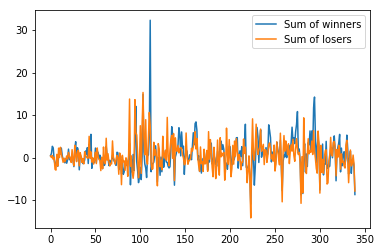

In [252]:
display(w)

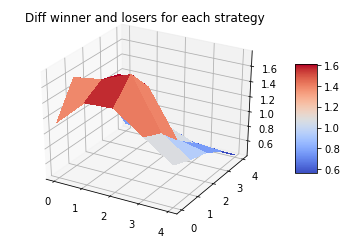

In [253]:
WL[np.isnan(WL)] = 0
WL_ = np.average(WL, axis=2)
WLdiff = WL_[:,:,0] / WL_[:,:,1]

x = y = np.arange(5)
X, Y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, WLdiff, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Diff winner and losers for each strategy')

In [254]:
a = WLdiff
np.where(a == a.max())
a[1,2]

1.7693607252899184

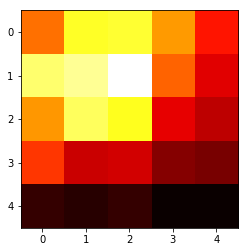

In [255]:
plt.imshow(WLdiff, cmap='hot', interpolation='nearest')

## Save to Excel

In [256]:
writer = pd.ExcelWriter('output.xlsx')
for io, o in enumerate(periods):
    for ih, h in enumerate(periods):
        data = WL[io, ih, :, :]
        data = data[~np.isnan(data).any(axis=1)]
        result_df = pd.DataFrame(data=data, columns=['sum winner', 'sum loser'])
        result_df.dropna(how='all', axis=1, inplace=True)
        result_df.to_excel(writer,"{}x{}".format(o,h))
writer.save()